In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from os.path import join
from os import getcwd
from IPython.display import clear_output

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import KFold

In [3]:
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.metrics import AUC # Area under the curve, default: ROC
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
from keras.regularizers import l1, l2

In [4]:
from functions import *

In [5]:
checkpoints_path = getcwd()+'\\checkpoints_C'

In [6]:
df = pd.read_csv('../../databases/diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
outlayers = {
    'BloodPressure': (40, np.Inf),
    'SkinThickness': (0, 80),
    'Insulin': (0, 400),
    'BMI': (0, 50)
}

zeros = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI'
]
x_df = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_df = df['Outcome']

In [8]:
def run_changing_state(x_dataset, y_dataset, model, state, direction, my_callbacks):
    # Split dataset into 15% test, 85% train 
    x_train, x_valid, y_train, y_valid = train_test_split(x_df, y_df, test_size=0.15, random_state=state)
    # Reemplazo los valores nulos y los outlayer
    x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
    x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
    # Normalizo los datasets
    x_train_norm, _norm_dict = normalize(x_train_clean, None)
    x_valid_norm, _norm_dict = normalize(x_valid_clean, _norm_dict)
    # Train model
    history_mlp_0 = mlp_model.fit(x_train_norm, y_train, validation_data=(x_valid_norm, y_valid),
                              batch_size=32, epochs=200,
                              verbose=0, callbacks=my_callbacks) 
    # Cargo el mejor modelo entrenado
    mlp_model.load_weights(direction)
    results = verify_model(mlp_model, x_train_norm, y_train, x_valid_norm, y_valid)
    return results

In [9]:
# Split dataset into 15% test, 85% train 
x_temp, x_test, y_temp, y_test = train_test_split(x_df, y_df, test_size=0.15)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.15)

In [10]:
# Reemplazo los valores nulos y los outlayer
x_train_clean, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
x_test_clean, _data = replace_outliers_zeros(x_test, outlayers, zeros, mean_median=True, data_to_replace=_data)
x_valid_clean, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
# Normalizo los datasets
x_train_norm, _norm_dict = normalize(x_train_clean, None)
x_valid_norm, _norm_dict = normalize(x_valid_clean, _norm_dict)
x_test_norm, _norm_dict = normalize(x_test_clean, _norm_dict)

In [11]:
stop_early = EarlyStopping(monitor='val_auc', patience=50)

### Definición de la red

In [12]:
mlp_0_checkpoint_callback = ModelCheckpoint(filepath=join(checkpoints_path, 'mlp_0'), save_weights_only=True, monitor='val_auc', mode='max', 
                                           save_best_only=True)
mlp_model = Sequential(name='mlp_0')

mlp_model.add(Dense(10, activation='relu', input_shape=(x_train_norm.shape[1],)))
mlp_model.add(Dense(5, activation='linear'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
mlp_model.summary()

Model: "mlp_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [13]:
mlp_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])

In [14]:
history_mlp_0 = mlp_model.fit(x_train_norm, y_train, validation_data=(x_valid_norm, y_valid),
                              batch_size=32, epochs=200,
                              verbose=1, callbacks=[mlp_0_checkpoint_callback]) 

Epoch 1/200
18/18 [==============================] - 1s 32ms/step - loss: 0.9992 - auc: 0.7221 - val_loss: 0.7284 - val_auc: 0.8045
Epoch 2/200
18/18 [==============================] - 0s 10ms/step - loss: 0.6302 - auc: 0.8223 - val_loss: 0.5678 - val_auc: 0.8050
Epoch 3/200
18/18 [==============================] - 0s 10ms/step - loss: 0.5254 - auc: 0.8332 - val_loss: 0.5214 - val_auc: 0.8069
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4991 - auc: 0.8374 - val_loss: 0.5117 - val_auc: 0.8060
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4899 - auc: 0.8399 - val_loss: 0.5062 - val_auc: 0.8031
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4849 - auc: 0.8414 - val_loss: 0.5050 - val_auc: 0.8009
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4886 - auc: 0.8387 - val_loss: 0.5006 - val_auc: 0.8057
Epoch 8/200
18/18 [==============================] - 0s 13ms/step - loss: 0.4716

In [15]:
# Cargo el mejor modelo entrenado
mlp_model.load_weights(join(checkpoints_path, 'mlp_0'))
verify_model(mlp_model, x_train_norm, y_train, x_valid_norm, y_valid)

,Set,AUC ROC,Especificidad,Sensibilidad,Valor Predictivo Positivo,Valor Predictivo Negativo
0,Train,0.900262,0.845070,0.778894,0.738095,0.872093
1,Validacion,0.821377,0.776119,0.741935,0.605263,0.866667


Salieron resultados interesantes, vamos a verificar si se mantiene al cambiar el random state al hacer split de los datos

In [16]:
mlp_state = Sequential(name='mlp_1')
mlp_state.add(Dense(10, activation='relu', input_shape=(x_train_norm.shape[1],)))
mlp_state.add(Dense(5, activation='linear'))
mlp_state.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
mlp_state.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
pesos_inicial = mlp_state.get_weights()
mlp_state.summary()

Model: "mlp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [17]:
train_auc = []
valid_auc = []
results = []

for i in range(10):
    print('Runing state', i)
    name  = 'mlp_state_{}'.format(i)
    mlp_state.set_weights(pesos_inicial)
    checkdir = join(checkpoints_path, name)
    temp_callback = ModelCheckpoint(filepath=checkdir, save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True)
    metrics = run_changing_state(x_temp, y_temp, mlp_state, i, checkdir, [temp_callback])
    results.append(metrics)
    train_auc.append(metrics['AUC ROC'][0])
    valid_auc.append(metrics['AUC ROC'][1])
    

Runing state 0
Runing state 1
Runing state 2
Runing state 3
Runing state 4
Runing state 5
Runing state 6
Runing state 7
Runing state 8
Runing state 9


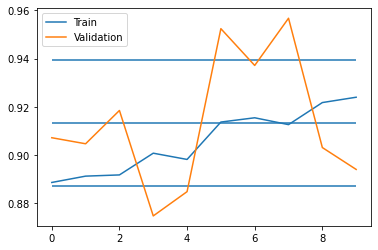

In [18]:
plt.plot(train_auc, label='Train')
plt.plot(valid_auc, label='Validation')
mean = np.mean(valid_auc)
std = np.std(valid_auc)
plt.hlines([mean+std, mean, mean-std], 0, 9)   
plt.legend()
plt.show()

Se puede observar que en la mayoria de los casos la metrica de validación da mejor que la metrica de train, con lo cual se puede inferir que el modelo tendrá una gran varianza debido a la poca cantidad de datos disponible para los parámetros que requiere entrenar el modelo. Por lo tanto una mejor opcion es utilizar k-folding en lugar de hold out validation

Ahora vamos a probar utilizar 1 o 2 capas ocultas, variando la cantidad de neuronas entre 5, 10 y 30, modificando la activacion entre relu y lineal. Para ello utilizaremos la tecnica de k-folding y la metrica de cada set de hyperparámetros sera el promedio de las metricas de cada fold. Una vez testeado esto se continuara buscando mejorar el modelo cambiando la regularizacion o agregando capas de Droput o Batch Normalization

In [40]:
folding = KFold(n_splits=5)

def train_model(x_dataset, y_dataset, model, name, batch, stopping_patiece=None):
    pesos_default = model.get_weights()
    folds = folding.split(x_dataset)
    auc_val = []
    results = []
    models = []
    curr = 0
    for train, valid in folds:
        # Split dataset
        x_train, x_valid = x_dataset.iloc[train], x_dataset.iloc[valid]
        y_train, y_valid = y_dataset.iloc[train], y_dataset.iloc[valid]
        
        # Proceso los datos
        x_train_c, _data = replace_outliers_zeros(x_train, outlayers, zeros, mean_median=True)
        x_valid_c, _data = replace_outliers_zeros(x_valid, outlayers, zeros, mean_median=True, data_to_replace=_data)
        # Normalizo los datasets
        x_train_n, _norm_dict = normalize(x_train_c, None)
        x_valid_n, _norm_dict = normalize(x_valid_c, _norm_dict)
    
        # Create callbacks
        checkdir = join(checkpoints_path, name+'f{}'.format(curr))
        temp_callback = ModelCheckpoint(filepath=checkdir, save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True)
        my_callbacks = [temp_callback]
        if stopping_patiece:
            my_callbacks.append(EarlyStopping(monitor='val_auc', patience=stopping_patiece))
        # Train model
        history = model.fit(x_train_n, y_train, validation_data=(x_valid_n, y_valid),
                            batch_size=batch, epochs=200,
                            verbose=0, callbacks=my_callbacks) 
        # Cargo el mejor modelo entrenado
        model.load_weights(checkdir)
        metrics = verify_model(model, x_train_n, y_train, x_valid_n, y_valid)
        auc_val.append(metrics['AUC ROC'][1])
        results.append(metrics)
        # Reset model for next training
        models.append(model.get_weights())
        model.set_weights(pesos_default)
        curr += 1
    return np.mean(auc_val), results, models    

1 capa

In [20]:
results = {}

for neuronas in [5, 10, 30]:
    for activation in ['linear', 'relu']:
        for batch in [32, 64]:
            name = 'n{}_b{}_{}'.format(neuronas, batch, activation)
            print('Testing ->', name)
            # Armo el modelo
            test_model = Sequential(name=name)
            test_model.add(Dense(neuronas, activation=activation, input_shape=(x_temp.shape[1],)))
            test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
            # Compilo el modelo
            test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
            auc, metrics, _ = train_model(x_temp, y_temp, test_model, name, batch, stopping_patiece=50)
            results[name] = (auc, metrics)
            print('Auc score = ', auc)

Testing -> n5_b32_linear
Auc score =  0.8271272156197718
Testing -> n5_b64_linear
Auc score =  0.8273518002462643
Testing -> n5_b32_relu
Auc score =  0.8304705854804466
Testing -> n5_b64_relu
Auc score =  0.8277850720497744
Testing -> n10_b32_linear
Auc score =  0.8284463108227241
Testing -> n10_b64_linear
Auc score =  0.8291442805705407
Testing -> n10_b32_relu
Auc score =  0.8311581125491634
Testing -> n10_b64_relu
Auc score =  0.8294404239203811
Testing -> n30_b32_linear
Auc score =  0.8282706327840765
Testing -> n30_b64_linear
Auc score =  0.829951175973485
Testing -> n30_b32_relu
Auc score =  0.8332847924711487
Testing -> n30_b64_relu
Auc score =  0.8321394820768198


In [21]:
for neuronas_1 in [5, 10, 30]:
    for neuronas_2 in [5, 10, 30]:
        for activation in ['linear', 'relu']:
            for batch in [32, 64]:
                name = 'na{}_nb{}_b{}_{}'.format(neuronas_1, neuronas_2, batch, activation)
                print('Testing ->', name)
                # Armo el modelo
                test_model = Sequential(name=name)
                test_model.add(Dense(neuronas_1, activation=activation, input_shape=(x_temp.shape[1],)))
                test_model.add(Dense(neuronas_2, activation=activation))
                test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
                # Compilo el modelo
                test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
                auc, metrics, _ = train_model(x_temp, y_temp, test_model, name, batch, stopping_patiece=50)
                results[name] = (auc, metrics)

Testing -> na5_nb5_b32_linear
Testing -> na5_nb5_b64_linear
Testing -> na5_nb5_b32_relu
Testing -> na5_nb5_b64_relu
Testing -> na5_nb10_b32_linear
Testing -> na5_nb10_b64_linear
Testing -> na5_nb10_b32_relu
Testing -> na5_nb10_b64_relu
Testing -> na5_nb30_b32_linear
Testing -> na5_nb30_b64_linear
Testing -> na5_nb30_b32_relu
Testing -> na5_nb30_b64_relu
Testing -> na10_nb5_b32_linear
Testing -> na10_nb5_b64_linear
Testing -> na10_nb5_b32_relu
Testing -> na10_nb5_b64_relu
Testing -> na10_nb10_b32_linear
Testing -> na10_nb10_b64_linear
Testing -> na10_nb10_b32_relu
Testing -> na10_nb10_b64_relu
Testing -> na10_nb30_b32_linear
Testing -> na10_nb30_b64_linear
Testing -> na10_nb30_b32_relu
Testing -> na10_nb30_b64_relu
Testing -> na30_nb5_b32_linear
Testing -> na30_nb5_b64_linear
Testing -> na30_nb5_b32_relu
Testing -> na30_nb5_b64_relu
Testing -> na30_nb10_b32_linear
Testing -> na30_nb10_b64_linear
Testing -> na30_nb10_b32_relu
Testing -> na30_nb10_b64_relu
Testing -> na30_nb30_b32_linear


Veo los 10 mejores resultados

In [22]:
sorted_results = list(reversed(sorted(results.items(), key=lambda x: x[1][0])))
for i in sorted_results[0:10]:
    print(i[0], '->', i[1][0])


na30_nb10_b64_relu -> 0.8446188136825024
na30_nb5_b32_relu -> 0.8418219204257831
na10_nb10_b64_relu -> 0.840528520785529
na30_nb30_b64_relu -> 0.8400677436723178
na30_nb10_b32_relu -> 0.8390895928721971
na10_nb5_b32_relu -> 0.8383933985619716
na5_nb5_b32_relu -> 0.8370869007082261
na30_nb5_b64_relu -> 0.8368245883944976
na10_nb5_b64_relu -> 0.835652844583813
na10_nb30_b32_relu -> 0.8346699915204978


Se puede observar como los de mejor performance son en su mayoria redes con 2 capas ocultas, y con gran cantidad de neuronas en cada una. Con estos resultados se buscara optimizar los hyperparámetros de los 3 mejores

In [23]:
results_2 = {}
neurona_1 = 30
for neurona_2 in [10, 30]:
    for act_n1 in ['relu', 'linear']:
        for act_n2 in ['relu', 'linear']:
            for batch in [32, 64]:
                for drop in [0, 1]:
                    name = 'na{}_nb{}_b{}_{}_{}_d{}'.format(neurona_1, neurona_2, batch, act_n1, act_n2, drop)
                    print('Testing ->', name)
                    # Armo el modelo
                    test_model = Sequential(name=name)

                    test_model.add(Dense(neurona_1, activation=act_n1, input_shape=(x_temp.shape[1],)))
                    if drop:
                        test_model.add(Dropout(rate=0.2))
                    test_model.add(Dense(neurona_2, activation=act_n2))

                    test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
                    # Compilo el modelo
                    test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
                    auc, metrics, _ = train_model(x_temp, y_temp, test_model, name, batch, stopping_patiece=50)
                    results_2[name] = (auc, metrics)
                
sorted_results_2 = list(reversed(sorted(results_2.items(), key=lambda x: x[1][0])))
for i in sorted_results_2[0:10]:
    print(i[0], '->', i[1][0])

Testing -> na30_nb10_b32_relu_relu_d0
Testing -> na30_nb10_b32_relu_relu_d1
Testing -> na30_nb10_b64_relu_relu_d0
Testing -> na30_nb10_b64_relu_relu_d1
Testing -> na30_nb10_b32_relu_linear_d0
Testing -> na30_nb10_b32_relu_linear_d1
Testing -> na30_nb10_b64_relu_linear_d0
Testing -> na30_nb10_b64_relu_linear_d1
Testing -> na30_nb10_b32_linear_relu_d0
Testing -> na30_nb10_b32_linear_relu_d1
Testing -> na30_nb10_b64_linear_relu_d0
Testing -> na30_nb10_b64_linear_relu_d1
Testing -> na30_nb10_b32_linear_linear_d0
Testing -> na30_nb10_b32_linear_linear_d1
Testing -> na30_nb10_b64_linear_linear_d0
Testing -> na30_nb10_b64_linear_linear_d1
Testing -> na30_nb30_b32_relu_relu_d0
Testing -> na30_nb30_b32_relu_relu_d1
Testing -> na30_nb30_b64_relu_relu_d0
Testing -> na30_nb30_b64_relu_relu_d1
Testing -> na30_nb30_b32_relu_linear_d0
Testing -> na30_nb30_b32_relu_linear_d1
Testing -> na30_nb30_b64_relu_linear_d0
Testing -> na30_nb30_b64_relu_linear_d1
Testing -> na30_nb30_b32_linear_relu_d0
Testing 

In [24]:
results_3 = {}
redes = [[30, 10, 64, 'relu', 'linear'],
         [30, 30, 32, 'linear', 'relu']]

for n1, n2, b, a1, a2 in redes:
    for drop in [0, 1]:
        name = 'na{}_nb{}_b{}_{}_{}_d{}_b'.format(n1, n2, b, a1, a2, drop)
        print('Testing ->', name)
        # Armo el modelo
        test_model = Sequential(name=name)

        test_model.add(Dense(n1, activation=a1, input_shape=(x_temp.shape[1],)))
        
        test_model.add(Dense(n2, activation=a2))
        
        if drop:
            test_model.add(Dropout(rate=0.5))
        else:
            test_model.add(BatchNormalization())
            
        test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.25)))
        # Compilo el modelo
        test_model.compile(optimizer=Adam(learning_rate=0.02), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
        auc, metrics, _ = train_model(x_temp, y_temp, test_model, name, b, stopping_patiece=50)
        results_3[name] = (auc, metrics)
        clear_output(wait=True)
                
sorted_results_3 = list(reversed(sorted(results_3.items(), key=lambda x: x[1][0])))
for i in sorted_results_3:
    print(i[0], '->', i[1][0])

na30_nb30_b32_linear_relu_d1_b -> 0.8476227031995652
na30_nb30_b32_linear_relu_d0_b -> 0.8428164488902864
na30_nb10_b64_relu_linear_d0_b -> 0.8414353281274268
na30_nb10_b64_relu_linear_d1_b -> 0.838907675546228


Finalmente no se pudieron conseguir mejoras sustanciales agregando capas de Droput o BatchNormalization

#### Optimizando hypperparametros del optimizador y regularizacion

In [25]:
results_4 = {}
redes = [[30, 10, 64, 'relu', 'linear'],
         [30, 30, 32, 'linear', 'relu']]

for i in [0, 1]:
    n1, n2, b, a1, a2 = redes[i]
    for lr in [5e-3, 0.01, 0.02, 0.05, 0.1, 0.5]:
        for l_2 in [0.01, 0.05, 0.1, 0.25, 0.5]:
            name = 'red{}_lr{}_l2{}_'.format(i, lr, l_2)
            print('Testing ->', name)
            # Armo el modelo
            test_model = Sequential(name=name)

            test_model.add(Dense(n1, activation=a1, input_shape=(x_temp.shape[1],)))

            test_model.add(Dense(n2, activation=a2))

            test_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l_2)))
            # Compilo el modelo
            test_model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
            auc, metrics, _ = train_model(x_temp, y_temp, test_model, name, b, stopping_patiece=50)
            results_4[name] = (auc, metrics)
            clear_output(wait=True)
                
sorted_results_4 = list(reversed(sorted(results_4.items(), key=lambda x: x[1][0])))
for i in sorted_results_4[:10]:
    print(i[0], '->', i[1][0])

red1_lr0.02_l20.5_ -> 0.8495475161025089
red0_lr0.1_l20.1_ -> 0.8461625165134885
red0_lr0.1_l20.25_ -> 0.8453358782084184
red1_lr0.05_l20.1_ -> 0.8434988535879414
red1_lr0.02_l20.25_ -> 0.8432147286239813
red0_lr0.02_l20.05_ -> 0.843123954592139
red1_lr0.05_l20.01_ -> 0.8429590729148458
red0_lr0.05_l20.1_ -> 0.8429587805234142
red1_lr0.02_l20.1_ -> 0.8428239507121829
red0_lr0.05_l20.25_ -> 0.8426730011011372


### Finalmente nos quedamos con le mejor modelo obtenido
El mismo cuenta con dos capas ocultas, con 30 neuronas cada una, utilizando el optimizador Adam con un learning rate de 0.05 y regularizacion L2 con l2=0.5

In [41]:
name = 'final'
print('Testing ->', name)
# Armo el modelo
final_model = Sequential(name=name)

final_model.add(Dense(30, activation='linear', input_shape=(x_temp.shape[1],)))

final_model.add(Dense(30, activation='relu'))

final_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.5)))
# Compilo el modelo
final_model.compile(optimizer=Adam(learning_rate=0.05), loss=BinaryCrossentropy(), metrics=[AUC(name='auc')])
auc, metrics, all_models = train_model(x_temp, y_temp, final_model, name, b, stopping_patiece=50)

Testing -> final


In [43]:
results = []
auc_test = []
for model in all_models:
    final_model.set_weights(model)
    metrics = verify_model(final_model, x_train_norm, y_train, x_test_norm, y_test)
    auc_test.append(metrics['AUC ROC'][1])
    results.append(metrics)

In [57]:
print('Test ACU ROC = {}'.format(np.mean(auc_test)))

Test ACU ROC = 0.9075910931174089


In [55]:
def predict(models, weights, x):
    l = len(weights)
    models.set_weights(weights[0])
    out = models.predict(x) / l
    
    for peso in weights[1:]:
        models.set_weights(peso)
        y = models.predict(x)
        out = out + y/l
    
    return out.copy()
        
def f2_threshold(model, weigths, x_train, y_train, x_validation, y_validation):
    y_train_pred = predict(model, weigths, x_train)
    y_valid_pred = predict(model, weigths, x_validation)
    th = np.linspace(0, 1, 100)
    f2score_v = []
    f2score_t = []
    max_f = [0, 0]
    for t in th:
        y_pred_t = (y_train_pred > t).astype(int)
        y_pred_v = (y_valid_pred > t).astype(int)
        score_t = fbeta_score(y_train, y_pred_t, beta=2)
        score_v = fbeta_score(y_validation, y_pred_v, beta=2)
        f2score_t.append(score_t)
        f2score_v.append(score_v)
        if score_v > max_f[0]:
            max_f[0] = score_v
            max_f[1] = t
    
    plt.plot(th, f2score_t, label='train')
    plt.plot(th, f2score_v, label='valid')
    
    plt.xlabel('Threshold')
    plt.ylabel('F2 score')
    
    plt.axvline(max_f[1], color='black', linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()
    plt.legend()
    plt.show()

### Eleccion del umbral de decision

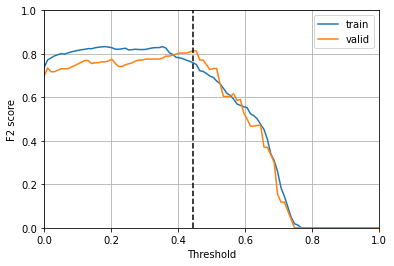

In [56]:
f2_threshold(final_model, all_models,  x_train_norm, y_train, x_valid_norm, y_valid)